In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
!pip install timm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import csv
import os
from tqdm.notebook import tqdm
import cv2
import albumentations as A
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim
import timm
from albumentations import (
    Compose,
    Normalize,
    ShiftScaleRotate,
    RandomBrightnessContrast,
    MotionBlur,
    CLAHE,
    HorizontalFlip
)

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import sys
import timm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
from tqdm.notebook import tqdm
import albumentations as A
from albumentations.pytorch import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import pandas as pd
pth = "/content/drive/Shareddrives/efficienet/train.csv"
df =pd.read_csv(pth)
df=df.groupby("image_id")["class_id"].agg(lambda s: (s == 14).sum()).reset_index().rename({"class_id": "num_normal_annotations"}, axis=1)
df.head()

,image_id,num_normal_annotations
0,000434271f63a053c4128a0ba6352c7f,3
1,00053190460d56c53cc3e57321387478,3
2,0005e8e3701dfb1dd93d53e2ff537b6e,0
3,0006e0a85696f6bb578e84fafa9a5607,3
4,0007d316f756b3fa0baea2ff514ce945,0


In [ ]:
def change(x):
    if (x==3):
        x=1
    return x
df['target'] = df['num_normal_annotations'].apply(lambda x: change(x))
df = df[["image_id","target"]]
df.head()

,image_id,target
0,000434271f63a053c4128a0ba6352c7f,1
1,00053190460d56c53cc3e57321387478,1
2,0005e8e3701dfb1dd93d53e2ff537b6e,0
3,0006e0a85696f6bb578e84fafa9a5607,1
4,0007d316f756b3fa0baea2ff514ce945,0


In [ ]:
from sklearn.model_selection import StratifiedKFold
import os
skf  =  StratifiedKFold(n_splits = 5, random_state = 42,shuffle = True)
folds = df.copy()
for f,(tr_idx,val_idx) in enumerate(skf.split(folds,folds.target)):
    folds.loc[val_idx,'fold'] = int(f)
folds['fold'] = folds['fold'].astype(int)
folds.image_id=folds.image_id+".png"
img_path = "/content/drive/Shareddrives/efficienet/data_full/"
df_paths = [os.path.join(img_path,x) for x in folds.image_id]
folds['path'] = df_paths
folds.head()
#folds.to_csv("/content/drive/Shareddrives/efficienet/folds.csv")

,image_id,target,fold,path
0,000434271f63a053c4128a0ba6352c7f.png,1,0,/content/drive/Shareddrives/efficienet/data_fu...
1,00053190460d56c53cc3e57321387478.png,1,3,/content/drive/Shareddrives/efficienet/data_fu...
2,0005e8e3701dfb1dd93d53e2ff537b6e.png,0,0,/content/drive/Shareddrives/efficienet/data_fu...
3,0006e0a85696f6bb578e84fafa9a5607.png,1,3,/content/drive/Shareddrives/efficienet/data_fu...
4,0007d316f756b3fa0baea2ff514ce945.png,0,1,/content/drive/Shareddrives/efficienet/data_fu...


In [ ]:
folds = pd.read_csv('/content/drive/Shareddrives/efficienet/folds.csv')
folds.head()

,Unnamed: 0,image_id,target,fold,path
0,0,000434271f63a053c4128a0ba6352c7f.png,1,0,/content/drive/Shareddrives/efficienet/data_fu...
1,1,00053190460d56c53cc3e57321387478.png,1,3,/content/drive/Shareddrives/efficienet/data_fu...
2,2,0005e8e3701dfb1dd93d53e2ff537b6e.png,0,0,/content/drive/Shareddrives/efficienet/data_fu...
3,3,0006e0a85696f6bb578e84fafa9a5607.png,1,3,/content/drive/Shareddrives/efficienet/data_fu...
4,4,0007d316f756b3fa0baea2ff514ce945.png,0,1,/content/drive/Shareddrives/efficienet/data_fu...


In [ ]:
train_aug = Compose([
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(scale_limit = 0.15, rotate_limit = 10, p = 0.5),
        RandomBrightnessContrast(p=0.5),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
    ])
val_aug = Compose([
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
    ])


In [ ]:
class Xray(Dataset):
    def __init__(self,df,augs=None):
        self.df = df
        self.augs = augs
    def __len__(self):
        return(len(self.df))
    def __getitem__(self,idx):
        img_src = self.df.loc[idx,'path']
        image = cv2.imread(img_src)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
        
        target = self.df.loc[idx,'target']
        
        if (self.augs):
            transformed = self.augs(image=image)
            image = transformed['image']
        image = torch.from_numpy(image.transpose((2, 0, 1))).float()
        return image,torch.tensor(target) 

In [ ]:
data = Xray(folds,augs = train_aug)
load = DataLoader(data,batch_size = 1)
img,target = next(iter(load))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


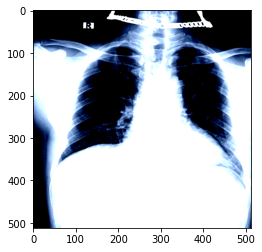

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img.squeeze(0).permute(1,2,0))

In [ ]:
model=timm.create_model('tf_efficientnet_b4_ns', pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 1)
model
ss=F.sigmoid(model(torch.randn(3,3,300,300)))
ss

tensor([[0.4994],
        [0.4905],
        [0.4963]], grad_fn=<SigmoidBackward0>)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_one_epoch(train_loader,model,optimizer,criterion,e,epochs):
    losses = AverageMeter()
    scores = AverageMeter()
    model.train()
    global_step = 0
    loop = tqdm(enumerate(train_loader),total = len(train_loader)) 
    for step,(image,labels) in loop:
        image = image.to(device)
        labels = labels.unsqueeze(1)
        labels= labels.to(device)
        output = model(image)
        batch_size = labels.size(0)
        loss = criterion(output,labels.float())
        
        out = F.sigmoid(output)
        outputs = out.cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        try:
            auc = sklearn.metrics.roc_auc_score(targets, outputs)
            losses.update(loss.item(), batch_size)
            scores.update(auc.item(), batch_size)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        
            loop.set_description(f"Epoch {e+1}/{epochs}")
            loop.set_postfix(loss = loss.item(), auc = auc.item(), stage = 'train')
        
            
        except ValueError:
            pass       
        
    return losses.avg,scores.avg


In [ ]:
def val_one_epoch(loader,model,optimizer,criterion):
    losses = AverageMeter()
    scores = AverageMeter()
    model.eval()
    global_step = 0
    loop = tqdm(enumerate(loader),total = len(loader))
    
    for step,(image,labels) in loop:
        image = image.to(device)
        labels = labels.unsqueeze(1)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            output = model(image)
        loss = criterion(output,labels.float())
        
        out = F.sigmoid(output)
        outputs = out.cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        try:
            auc = sklearn.metrics.roc_auc_score(targets, outputs)
            losses.update(loss.item(), batch_size)
            scores.update(auc.item(), batch_size)
            loop.set_postfix(loss = loss.item(), auc = auc.item(), stage = 'valid')
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        except ValueError:
            pass
               
    return losses.avg,scores.avg

In [ ]:
%cd /content/drive/Shareddrives/efficienet
file_csv = "/content/drive/Shareddrives/efficienet/save_csv/save_result_train15.csv"

def fit(model,fold_n,training_batch_size=4,validation_batch_size=4):
    train_data=folds[folds.fold != fold_n]
    val_data=folds[folds.fold == fold_n]
    train_data= Xray(train_data.reset_index(drop=True),augs = train_aug)
    val_data= Xray(val_data.reset_index(drop=True),augs = val_aug)
    
    
    train_loader = DataLoader(train_data,
                             shuffle=True,
                        num_workers=1,
                        batch_size=training_batch_size)
    valid_loader = DataLoader(val_data,
                             shuffle=False,
                        num_workers=1,
                        batch_size=validation_batch_size)
    checkpoint = torch.load("/content/drive/Shareddrives/efficienet/checkpoint/last_ checkpoint_epoch0.pt")
    model = model
    model.load_state_dict(checkpoint['weight'])###### load model
    model.to(device)
    criterion=nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 3,verbose = True)
    val_auct =checkpoint['val_auc']
    num_epoch = 1
    epochs= 15 
    best_acc = val_auct
    #best_acc =0
    print(best_acc)
    for e in range(num_epoch,epochs): # nhớ thêm numepoch
        
        train_loss,train_auc = train_one_epoch(train_loader,model,optimizer,criterion,e,epochs)
        #scheduler.step()
        print(f'For epoch {e+1}/{epochs}')
        print(f'average train_loss {train_loss}')
        print(f'average train_auc {train_auc}' )
        
        val_loss,val_auc = val_one_epoch(valid_loader,model,optimizer,criterion)
        
        scheduler.step(val_loss)
        
        print(f'avarage val_loss { val_loss }')
        print(f'avarage val_auc {val_auc}')
        ### save checkpoint
        check ={
            'weight':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'train_loss':train_loss,
            'val_loss': val_loss,
            'train_auc': train_auc,
            'val_auc' : val_auc,
            'epochs':e
        }
        torch.save(check,'/content/drive/Shareddrives/efficienet/checkpoint/'+ f'last_ checkpoint_epoch{e}.pt')
        ## lưu vào file csv
        with open(file_csv,'a',newline='') as f:
              fieldnames = ['epochs','train_loss','val_loss','train_auc','val_auc']
              writer = csv.DictWriter(f, fieldnames=fieldnames,)
              writer.writerow({'epochs':e,'train_loss':train_loss,'val_loss':val_loss,'train_auc':train_auc,'val_auc':val_auc})

        if (val_auc>best_acc):
            best_acc =val_auc
            print(f'saving model for {best_acc}')
            torch.save(model.state_dict(),'/content/drive/Shareddrives/efficienet/output/'+ f'Fold {fold_n} model with val_acc {best_acc}.pth') 



/content/drive/Shareddrives/efficienet


In [ ]:
fit(model,0)

0.9422727272727275


  0%|          | 0/3000 [00:00<?, ?it/s]

For epoch 2/15
average train_loss 0.28712287331599606
average train_auc 0.9549752363800098


  0%|          | 0/750 [00:00<?, ?it/s]

avarage val_loss 0.4269440877340226
avarage val_auc 0.9636363636363638
saving model for 0.9636363636363638


  0%|          | 0/3000 [00:00<?, ?it/s]

For epoch 3/15
average train_loss 0.2613116461690557
average train_auc 0.9632142318709497


  0%|          | 0/750 [00:00<?, ?it/s]

avarage val_loss 0.25754651559506203
avarage val_auc 0.9739393939393941
saving model for 0.9739393939393941


  0%|          | 0/3000 [00:00<?, ?it/s]

For epoch 4/15
average train_loss 0.23814152364322463
average train_auc 0.9682628062360806


  0%|          | 0/750 [00:00<?, ?it/s]

avarage val_loss 0.19647140921932243
avarage val_auc 0.9771212121212121
saving model for 0.9771212121212121


  0%|          | 0/3000 [00:00<?, ?it/s]

For epoch 5/15
average train_loss 0.22636180165856223
average train_auc 0.9731448234590071


  0%|          | 0/750 [00:00<?, ?it/s]

avarage val_loss 0.24441807975599658
avarage val_auc 0.9763636363636363


  0%|          | 0/3000 [00:00<?, ?it/s]

For epoch 6/15
average train_loss 0.20450723059136267
average train_auc 0.9759457849270191


  0%|          | 0/750 [00:00<?, ?it/s]

avarage val_loss 0.22384805216506887
avarage val_auc 0.9795454545454545
saving model for 0.9795454545454545


  0%|          | 0/3000 [00:00<?, ?it/s]

For epoch 7/15
average train_loss 0.19919251747353545
average train_auc 0.9790257104194866


  0%|          | 0/750 [00:00<?, ?it/s]

avarage val_loss 0.35527536613337524
avarage val_auc 0.9801515151515152
saving model for 0.9801515151515152


  0%|          | 0/3000 [00:00<?, ?it/s]

For epoch 8/15
average train_loss 0.18269619802738207
average train_auc 0.9800030070666073


  0%|          | 0/750 [00:00<?, ?it/s]

avarage val_loss 0.1941941163509645
avarage val_auc 0.9812121212121211
saving model for 0.9812121212121211


  0%|          | 0/3000 [00:00<?, ?it/s]

For epoch 9/15
average train_loss 0.181419784100221
average train_auc 0.9816554809843399


  0%|          | 0/750 [00:00<?, ?it/s]

avarage val_loss 0.15569506172567013
avarage val_auc 0.9843939393939395
saving model for 0.9843939393939395


  0%|          | 0/3000 [00:00<?, ?it/s]

For epoch 10/15
average train_loss 0.16796961802255544
average train_auc 0.9839483948394846


  0%|          | 0/750 [00:00<?, ?it/s]

avarage val_loss 0.17237536869273754
avarage val_auc 0.9784848484848484


  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
for i in range(1,10):
  print(i)

1
2
3
4
5
6
7
8
9
